In [1]:
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
from sklearn.utils import class_weight

from keras.models import load_model
from sklearn import preprocessing

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from classification_models.tfkeras import Classifiers
import efficientnet.tfkeras as efn

In [2]:
# avoid tensorflow to get all gpu memory
physical_devices = tf.config.list_physical_devices('GPU')
try:
    for gpu in physical_devices:
        tf.config.experimental.set_memory_growth(gpu, True)
except:
    logger.info('error accessing gpu devices...')
    pass

### Collecting information to use in models (from directory)

In [3]:
root_train = '../data/raw/vehicle/train/train/'

In [4]:
root_test = '../data/raw/vehicle/test/testset/'

In [ ]:
# Data Generator for the train data
train_datagen = ImageDataGenerator(rescale=1. / 255.,
                                   validation_split=0.2,
                                   horizontal_flip=True, 
                                   rotation_range=10, 
                                   width_shift_range=.1, 
                                   height_shift_range=.1)

In [ ]:
validation_datagen = ImageDataGenerator(rescale=1. / 255.)

In [ ]:
train_generator = train_datagen.flow_from_directory(root_train, 
                                                    target_size=(224, 224),
                                                    shuffle=True,
                                                    seed=13,
                                                    class_mode='categorical', 
                                                    batch_size=32,
                                                    subset="training")

In [ ]:
validation_generator = train_datagen.flow_from_directory(root_train, 
                                                              target_size=(224, 224),
                                                              shuffle=True, 
                                                              seed=13,
                                                              class_mode='categorical', 
                                                              batch_size=32,
                                                              subset="validation")

In [ ]:
predict_generator = validation_datagen.flow_from_directory(root_test,
                                                           target_size=(224, 224),
                                                           shuffle=False,
                                                           class_mode='categorical', 
                                                           batch_size=32)

### Collecting information to use in models (from dataframe)

In [5]:
data_train = []
data_test = []
id_line = []

In [6]:
for category in sorted(os.listdir(root_train)):
    for file in sorted(os.listdir(os.path.join(root_train, category))):
        data_train.append((category, os.path.join(root_train, category, file)))

In [7]:
count = 0
for file in sorted(os.listdir(os.path.join(root_test))):
    data_test.append((os.path.join(root_test, file)))
    id_line.append(count)
    count += 1

In [8]:
train_df = pd.DataFrame(data_train, columns=['class','file_path']).sample(frac=1.0)
train_df.head()

,class,file_path
21163,Motorcycle,../data/raw/vehicle/train/train/Motorcycle/000...
5926,Boat,../data/raw/vehicle/train/train/Boat/001949_02...
26086,Truck,../data/raw/vehicle/train/train/Truck/004589_0...
8841,Boat,../data/raw/vehicle/train/train/Boat/003859_01...
23047,Motorcycle,../data/raw/vehicle/train/train/Motorcycle/004...


In [9]:
train_df['class'].unique()

array(['Motorcycle', 'Boat', 'Truck', 'Car', 'PickUp', 'Bicycle', 'Bus',
       'Taxi', 'Van', 'Ambulance', 'Helicopter', 'Segway', 'Snowmobile',
       'Limousine', 'Tank'], dtype=object)

In [10]:
print(f'There are {len(train_df)} images on train folder')

There are 27290 images on train folder


In [11]:
test_df = pd.DataFrame(data_test, columns=['file_path'])
test_df.head()

,file_path
0,../data/raw/vehicle/test/testset/000000.jpg
1,../data/raw/vehicle/test/testset/000001.jpg
2,../data/raw/vehicle/test/testset/000002.jpg
3,../data/raw/vehicle/test/testset/000003.jpg
4,../data/raw/vehicle/test/testset/000004.jpg


In [12]:
print(f'There are {len(test_df)} images on test folder')

There are 7669 images on test folder


In [13]:
# Data Generator for the train data
data_generator = ImageDataGenerator(rescale=1. / 255., 
                                    validation_split=0.2, 
                                    horizontal_flip=True, 
                                    rotation_range=10,
                                    width_shift_range=.1, 
                                    height_shift_range=.1)

In [14]:
train_generator= data_generator.flow_from_dataframe(
            dataframe=train_df,
            directory=None,
            x_col='file_path',
            y_col='class',
            has_ext=False,
            subset="training",
            batch_size=32,
            seed=42,
            shuffle=True,
            class_mode="categorical",
            target_size= (224, 224))

Found 21832 validated image filenames belonging to 15 classes.


In [15]:
validation_generator = data_generator.flow_from_dataframe(
            dataframe=train_df,
            directory=None,
            x_col='file_path',
            y_col='class',
            has_ext=False,
            subset="validation",
            batch_size=32,
            seed=42,
            shuffle=True,
            class_mode="categorical",
            target_size= (224, 224))

Found 5458 validated image filenames belonging to 15 classes.


In [16]:
test_generator = ImageDataGenerator(rescale=1. / 255.)

In [17]:
predict_generator = test_generator.flow_from_dataframe(
            dataframe=test_df,
            x_col='file_path',
            y_col=None,
            batch_size=32,
            shuffle=False,
            class_mode=None,
            target_size= (224, 224))

Found 7669 validated image filenames.


## Defining mandatory proccess to train models

In [18]:
# Class weights
class_weights_lst = class_weight.compute_class_weight('balanced', 
                                                  np.unique(train_generator.classes), 
                                                  train_generator.classes)

/home/christian/miniconda3/envs/ironhack_env/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14], y=[2, 12, 4, 1, 14, 14, 7, 2, 1, 2, 14, 2, 7, 4, 4, 1, 4, 7, 0, 7, 2, 2, 3, 4, 4, 7, 4, 2, 2, 2, 7, 2, 7, 5, 2, 2, 2, 4, 14, 7, 1, 4, 2, 3, 2, 7, 4, 2, 11, 4, 2, 12, 13, 13, 1, 4, 4, 5, 12, 4, 5, 4, 4, 5, 12, 2, 7, 4, 2, 12, 13, 12, 13, 2, 4, 4, 3, 2, 2, 3, 7, 2, 2, 13, 4, 4, 7, 2, 2, 4, 3, 2, 7, 2, 4, 4, 0, 2, 7, 2, 2, 14, 2, 4, 4, 2, 12, 4, 2, 12, 2, 2, 4, 4, 2, 4, 2, 5, 1, 4, 4, 2, 14, 2, 13, 2, 4, 4, 2, 8, 2, 7, 13, 5, 1, 7, 4, 11, 4, 10, 7, 2, 4, 4, 2, 4, 7, 4, 5, 4, 7, 2, 2, 4, 11, 2, 3, 2, 2, 4, 2, 4, 4, 4, 2, 2, 4, 4, 4, 13, 12, 13, 4, 2, 4, 3, 2, 7, 13, 3, 2, 14, 12, 2, 2, 7, 1, 4, 14, 13, 3, 2, 4, 7, 4, 4, 7, 3, 4, 7, 3, 2, 3, 12, 2, 4, 2, 4, 2, 2, 3, 4, 2, 7, 2, 4, 4, 10, 2, 4, 2, 2, 4, 4, 4, 2, 7, 2, 2, 2, 7, 9, 7, 13, 14, 4, 2, 2, 4, 2, 12, 14, 2, 1, 14, 2, 12, 4, 4, 1, 5, 4, 2, 7, 13, 2, 1, 11,

In [19]:
class_weights = dict(zip(np.unique(train_generator.classes), class_weights_lst))

In [ ]:
# the training stops if you see that the cost function does not improve after certain epochs
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7, verbose=1, min_delta=1e-4)

In [21]:
# if training does not improve after specific epochs, reduce the learning rate value by improving training
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=4, verbose=1, min_delta=1e-4)

## Testing some models

### Simple model: Sequential

In [ ]:
#simple model
model = Sequential([Conv2D(16, 3, padding='same', activation='relu', input_shape=(224, 224, 3)),
                    MaxPooling2D(),
                    Dropout(0.2),
                    Conv2D(32, 3, padding='same', activation='relu'),
                    MaxPooling2D(),
                    Conv2D(64, 3, padding='same', activation='relu'),
                    MaxPooling2D(),
                    Dropout(0.2),
                    Flatten(),
                    Dense(512, activation='relu'),
                    Dense(17, activation='softmax')])

In [ ]:
# Compile the model
optimizer = Adam(lr=0.0001)
model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
model.summary()

In [ ]:
# Save the best model
file_path = f'../data/results/{model.name}.h5'
best_model = tf.keras.callbacks.ModelCheckpoint(file_path, 
                                                save_best_only=True, 
                                                monitor='val_accuracy',
                                                verbose=1,
                                                save_weights_only=False)

In [ ]:
# Train model
history = model.fit(train_generator,
                    steps_per_epoch=22443 // 32,
                    epochs=100,
                    validation_data=validation_generator,
                    validation_steps=5602 // 32,
                    class_weight=class_weights,
                    callbacks=[earlyStopping, reduce_lr, best_model])

In [ ]:
# accuracy & validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

In [ ]:
# lossvalues & validation lossvalues
loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
# Plot training
epochs_range = range(100)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.grid()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.grid()
plt.title('Training and Validation Loss')

### ResNet50 Model

In [ ]:
base_model = tf.keras.applications.resnet50.ResNet50(include_top=False, 
                                                     weights='imagenet', 
                                                     pooling='max')

In [ ]:
model2 = Sequential()
model2.add(base_model)
model2.add(Dense(1024, activation='relu'))
model2.add(Dense(15, activation='softmax'))

In [ ]:
# Compile the model
optimizer = Adam(lr=0.0001)
model2.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
model2.summary()

In [ ]:
# Save the best model
file_path2 = f'../data/results/{model2.name}.h5'
best_model2 = tf.keras.callbacks.ModelCheckpoint(file_path2, 
                                                save_best_only=True, 
                                                monitor='val_accuracy',
                                                verbose=1,
                                                save_weights_only=False)

In [ ]:
# Train model
history2 = model2.fit(train_generator,
                    steps_per_epoch=21833 // 32,
                    epochs=100,
                    validation_data=validation_generator,
                    validation_steps=5458 // 32,
                    class_weight=class_weights,
                    callbacks=[earlyStopping, reduce_lr, best_model2])

In [ ]:
# For complete model
# model2.save(f'../data/results/complete_model_{model2.name}.h5')

In [ ]:
# To load the complete model
# file_path20 = f'../data/results/complete_model_{model2.name}.h5'
# history20 = load_model(file_path20)

In [ ]:
# accuracy & validation accuracy
acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']

In [ ]:
# lossvalues & validation lossvalues
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

In [ ]:
# Plot training
epochs_range = range(45)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc2, label='Training Accuracy')
plt.plot(epochs_range, val_acc2, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.grid()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss2, label='Training Loss')
plt.plot(epochs_range, val_loss2, label='Validation Loss')
plt.legend(loc='upper right')
plt.grid()
plt.title('Training and Validation Loss')

In [ ]:
model2.save(f'../data/results/complete_model_{model2.name}.h5')

### MobileNet model

In [22]:
basemodel, _ = Classifiers.get('mobilenetv2')

base_model3 = basemodel(input_shape=(224, 224, 3),
                       weights='imagenet',
                       include_top=False)
x = GlobalAveragePooling2D()(base_model3.output)
output = Dense(15, activation='softmax')(x)
model3 = Model(inputs=[base_model3.input], outputs=[output])

In [23]:
# Compile the model
optimizer = Adam(lr=0.0001)
model3.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
model3.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
______________________________________________________________________________________________

In [24]:
# Save the best model
file_path3 = f'../data/results/Classifiers/{model3.name}.h5'
best_model3 = tf.keras.callbacks.ModelCheckpoint(file_path3, 
                                                 save_best_only=True, 
                                                 monitor='val_accuracy',
                                                 verbose=1,
                                                 save_weights_only=False)

In [25]:
# Train model
history3 = model3.fit(train_generator,
                    steps_per_epoch=21833 // 32,
                    epochs=100,
                    validation_data=validation_generator,
                    validation_steps=5458 // 32,
                    class_weight=class_weights,
                    callbacks=[earlyStopping, reduce_lr, best_model3])

Epoch 1/100
682/682 [==============================] - ETA: 0s - loss: 0.8684 - accuracy: 0.6593
Epoch 00001: val_accuracy improved from -inf to 0.72739, saving model to ../data/results/Classifiers/model.h5
682/682 [==============================] - 560s 821ms/step - loss: 0.8684 - accuracy: 0.6593 - val_loss: 0.8073 - val_accuracy: 0.7274 - lr: 1.0000e-04
Epoch 2/100
682/682 [==============================] - ETA: 0s - loss: 0.3949 - accuracy: 0.8049
Epoch 00002: val_accuracy improved from 0.72739 to 0.80515, saving model to ../data/results/Classifiers/model.h5
682/682 [==============================] - 549s 805ms/step - loss: 0.3949 - accuracy: 0.8049 - val_loss: 0.6092 - val_accuracy: 0.8051 - lr: 1.0000e-04
Epoch 3/100
682/682 [==============================] - ETA: 0s - loss: 0.2917 - accuracy: 0.8454
Epoch 00003: val_accuracy improved from 0.80515 to 0.84357, saving model to ../data/results/Classifiers/model.h5
682/682 [==============================] - 548s 804ms/step - loss: 0.

In [26]:
model3.save(f'../data/results/complete_model_{model3.name}.h5')

In [ ]:
# To load only the weight model
# history3 = model3.load_weights(file_path3)

In [27]:
# accuracy & validation accuracy
acc3 = history3.history['accuracy']
val_acc3 = history3.history['val_accuracy']

In [28]:
# lossvalues & validation lossvalues
loss3 = history3.history['loss']
val_loss3 = history3.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

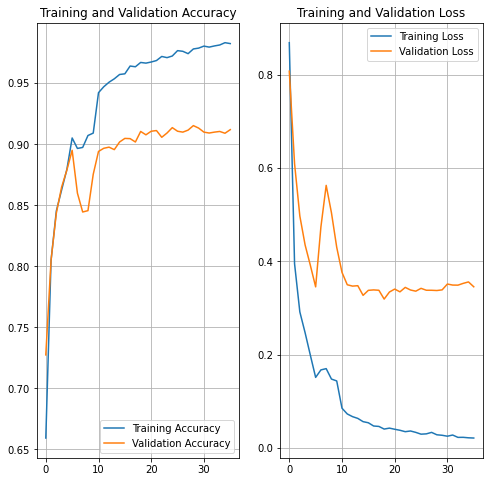

In [29]:
# Plot training
epochs_range = range(36)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc3, label='Training Accuracy')
plt.plot(epochs_range, val_acc3, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.grid()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss3, label='Training Loss')
plt.plot(epochs_range, val_loss3, label='Validation Loss')
plt.legend(loc='upper right')
plt.grid()
plt.title('Training and Validation Loss')

### NasNet_keras model

In [ ]:
base_model4 = tf.keras.applications.nasnet.NASNetLarge(include_top =False,
                                                       input_shape=(331, 331, 3),
                                                       weights='imagenet', 
                                                       pooling='max')

In [ ]:
model4 = Sequential()
model4.add(base_model4)
model4.add(Dense(127, activation='relu'))
model4.add(Dense(17, activation='softmax'))

In [ ]:
# Compile the model
optimizer = Adam(lr=0.0001)
model4.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
model4.summary()

In [ ]:
# Save the best model
file_path4 = f'../data/results/{model4.name}.h5'
best_model4 = tf.keras.callbacks.ModelCheckpoint(file_path4, 
                                                 save_best_only=True, 
                                                 monitor='val_accuracy',
                                                 verbose=1,
                                                 save_weights_only=True)

In [ ]:
# Train model
history4 = model4.fit(train_generator,
                    steps_per_epoch=22443 // 32,
                    epochs=100,
                    validation_data=validation_generator,
                    validation_steps=5602 // 32,
                    class_weight=class_weights,
                    callbacks=[earlyStopping, reduce_lr, best_model4])

In [ ]:
# accuracy & validation accuracy
acc4 = history4.history4['accuracy']
val_acc4 = history4.history4['val_accuracy']

In [ ]:
# lossvalues & validation lossvalues
loss4 = history4.history4['loss']
val_loss4 = history4.history4['val_loss']

In [ ]:
# Plot training
epochs_range = range(100)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc4, label='Training Accuracy')
plt.plot(epochs_range, val_acc4, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.grid()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss4, label='Training Loss')
plt.plot(epochs_range, val_loss4, label='Validation Loss')
plt.legend(loc='upper right')
plt.grid()
plt.title('Training and Validation Loss')

### NasNetLarge model

In [ ]:
NASNetLarge, _ = Classifiers.get('nasnetlarge')

In [ ]:
base_model5 = NASNetLarge(include_top=False,
                          input_shape=(331, 331, 3), 
                          weights='imagenet')
x = GlobalAveragePooling2D()(base_model5.output)
output = Dense(17, activation='softmax')(x)
model5 = Model(inputs=[base_model5.input], outputs=[output])

In [ ]:
# Compile the model
optimizer = Adam(lr=0.0001)
model5.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
model5.summary()

In [ ]:
# Save the best model
file_path5 = f'../data/results/{model5.name}.h5'
best_model5 = tf.keras.callbacks.ModelCheckpoint(file_path5, 
                                                 save_best_only=True, 
                                                 monitor='val_accuracy',
                                                 verbose=1,
                                                 save_weights_only=True)

In [ ]:
# Train model
history5 = model5.fit(train_generator,
                    steps_per_epoch=22443 // 32,
                    epochs=100,
                    validation_data=validation_generator,
                    validation_steps=5602 // 32,
                    class_weight=class_weights,
                    callbacks=[earlyStopping, reduce_lr, best_model5])

In [ ]:
# accuracy & validation accuracy
acc5 = history5.history5['accuracy']
val_acc5 = history5.history5['val_accuracy']

In [ ]:
# lossvalues & validation lossvalues
loss5 = history5.history5['loss']
val_loss5 = history5.history5['val_loss']

In [ ]:
# Plot training
epochs_range = range(100)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc5, label='Training Accuracy')
plt.plot(epochs_range, val_acc5, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.grid()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss5, label='Training Loss')
plt.plot(epochs_range, val_loss5, label='Validation Loss')
plt.legend(loc='upper right')
plt.grid()
plt.title('Training and Validation Loss')

### EfficientNet model

In [ ]:
base_model6 = efn.EfficientNetB7(include_top=False, 
                                input_shape=(224, 224, 3),
                                weights='imagenet', 
                                pooling='max')

In [ ]:
model6 = Sequential()
model6.add(base_model6)
model6.add(Dense(512, activation='relu'))
model6.add(Dense(17, activation='softmax'))

In [ ]:
# Compile the model
optimizer = Adam(lr=0.0001)
model6.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
model6.summary()

In [ ]:
# Save the best model
file_path6 = f'../data/results/Sequential/EfficientNet/{model6.name}.h5'
best_model6 = tf.keras.callbacks.ModelCheckpoint(file_path6, 
                                                 save_best_only=True, 
                                                 monitor='val_accuracy',
                                                 verbose=1,
                                                 save_weights_only=True)

In [ ]:
# Train model
history6 = model6.fit(train_generator,
                    steps_per_epoch=22443 // 32,
                    epochs=100,
                    validation_data=validation_generator,
                    validation_steps=5602 // 32,
                    class_weight=class_weights,
                    callbacks=[earlyStopping, reduce_lr, best_model6])

In [ ]:
# accuracy & validation accuracy
acc6 = history6.history['accuracy']
val_acc6 = history6.history['val_accuracy']

In [ ]:
# lossvalues & validation lossvalues
loss6 = history6.history['loss']
val_loss6 = history6.history['val_loss']

In [ ]:
# Plot training
epochs_range = range(100)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc6, label='Training Accuracy')
plt.plot(epochs_range, val_acc6, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.grid()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss6, label='Training Loss')
plt.plot(epochs_range, val_loss6, label='Validation Loss')
plt.legend(loc='upper right')
plt.grid()
plt.title('Training and Validation Loss')

### InceptionV3

In [ ]:
from keras.applications.inception_v3 import InceptionV3

In [ ]:
base_model7 = InceptionV3(include_top=False,
                          weights="imagenet",
                          input_shape=(224,224,3),
                          pooling='max')

In [ ]:
model7 = Sequential()
model7.add(base_model7)
model7.add(Dense(512, activation='relu'))
model7.add(Dense(17, activation='softmax'))

In [ ]:
# Compile the model
optimizer = Adam(lr=0.0001)
model7.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
model7.summary()

In [ ]:
# Save the best model
file_path7 = f'../data/results/Sequential/InceptionV3/{model7.name}.h5'
best_model7 = tf.keras.callbacks.ModelCheckpoint(file_path7, 
                                                 save_best_only=True, 
                                                 monitor='val_accuracy',
                                                 verbose=1,
                                                 save_weights_only=True)

In [ ]:
# Train model
history7 = model7.fit(train_generator,
                    steps_per_epoch=22443 // 32,
                    epochs=100,
                    validation_data=validation_generator,
                    validation_steps=5602 // 32,
                    class_weight=class_weights,
                    callbacks=[earlyStopping, reduce_lr, best_model7])

In [ ]:
# accuracy & validation accuracy
acc7 = history7.history['accuracy']
val_acc7 = history7.history['val_accuracy']

In [ ]:
# lossvalues & validation lossvalues
loss7 = history7.history['loss']
val_loss7 = history7.history['val_loss']

In [ ]:
# Plot training
epochs_range = range(100)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc7, label='Training Accuracy')
plt.plot(epochs_range, val_acc7, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.grid()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss7, label='Training Loss')
plt.plot(epochs_range, val_loss7, label='Validation Loss')
plt.legend(loc='upper right')
plt.grid()
plt.title('Training and Validation Loss')